In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import pandas as pd
from itertools import zip_longest
import numpy as np
%matplotlib inline     
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from helper_simulation import *
from helper_util import *
import pandas as pd
import os
import pyreadr


max_id=get_max("exp_result")
exp_str=""
log_path=f"exp_result/{str(max_id)}.dust"

logger=get_logger(log_path)

# 转换R对象到pandas的增强支持
pandas2ri.activate()

# 加载RData文件
loadRData = robjects.r['load']
loadRData("/home/jianj0c/project/STP/code_publish/tailSCM/tmp/TS_anom_clust.RData")

# 获取R环境中的聚类结果并转换
TS_anom_clust = robjects.r['TS_anom_clust']

# 调试：增强对象结构分析
print("R对象类型:", type(TS_anom_clust))
print("对象长度:", len(TS_anom_clust))

# 修复列名处理：使用rpy2的NULL检查方法
# 获取列名（处理R的NULL类型）
if robjects.r['is.null'](TS_anom_clust.names)[0]:
    column_names = [f"Cluster_{i+1}" for i in range(len(TS_anom_clust))]
else:
    # 处理名称与值长度不一致的情况
    column_names = list(TS_anom_clust.names)
    if len(column_names) < len(TS_anom_clust):
        column_names += [f"Cluster_{i+1}" for i in range(len(column_names), len(TS_anom_clust))]

# 安全转换每个元素
data_dict = {}
for i, (name, value) in enumerate(zip(column_names, TS_anom_clust)):
    try:
        # 转换值并处理可能的维度问题
        converted = pandas2ri.rpy2py(value)
        # 处理单元素数组和普通数组的情况
        data_dict[name] = converted if converted.ndim > 0 else [converted]
    except Exception as e:
        print(f"转换第{i}列 '{name}' 时出错: {str(e)}")
        # 使用原始值作为备用方案
        data_dict[name] = list(value) if hasattr(value, '__iter__') else value

# 创建DataFrame（修复转置问题）
max_length = max(len(v) for v in data_dict.values())
data_df = pd.DataFrame({
    k: v + [pd.NA]*(max_length - len(v)) if len(v) < max_length else v 
    for k, v in data_dict.items()
})

# 增强调试输出
print("\n转换结果摘要：")
print(f"DataFrame形状: {data_df.shape}")
print("前3行数据示例:")
print(data_df.head(3))
print("\n列数据类型:")
print(data_df.dtypes)

exp_result/147.dust/xx.log
R对象类型: <class 'rpy2.robjects.vectors.ListVector'>
对象长度: 6
转换第0列 'Cluster_1' 时出错: Conversion 'rpy2py' not defined for objects of type '<class 'numpy.ndarray'>'
转换第1列 'Cluster_2' 时出错: Conversion 'rpy2py' not defined for objects of type '<class 'numpy.ndarray'>'
转换第2列 'Cluster_3' 时出错: Conversion 'rpy2py' not defined for objects of type '<class 'numpy.ndarray'>'
转换第3列 'Cluster_4' 时出错: Conversion 'rpy2py' not defined for objects of type '<class 'numpy.ndarray'>'
转换第4列 'Cluster_5' 时出错: Conversion 'rpy2py' not defined for objects of type '<class 'numpy.ndarray'>'
转换第5列 'Cluster_6' 时出错: Conversion 'rpy2py' not defined for objects of type '<class 'numpy.ndarray'>'

转换结果摘要：
DataFrame形状: (13784, 6)
前3行数据示例:
   Cluster_1  Cluster_2  Cluster_3  Cluster_4  Cluster_5  Cluster_6
0  -0.218681  -1.333495  -0.847517  -0.723406  -1.100649  -1.262696
1   0.197802  -1.277476  -0.778658  -0.883333  -1.013506  -0.798348
2   0.192198  -1.231068  -0.588389  -1.362319  -0.777662  -0.49

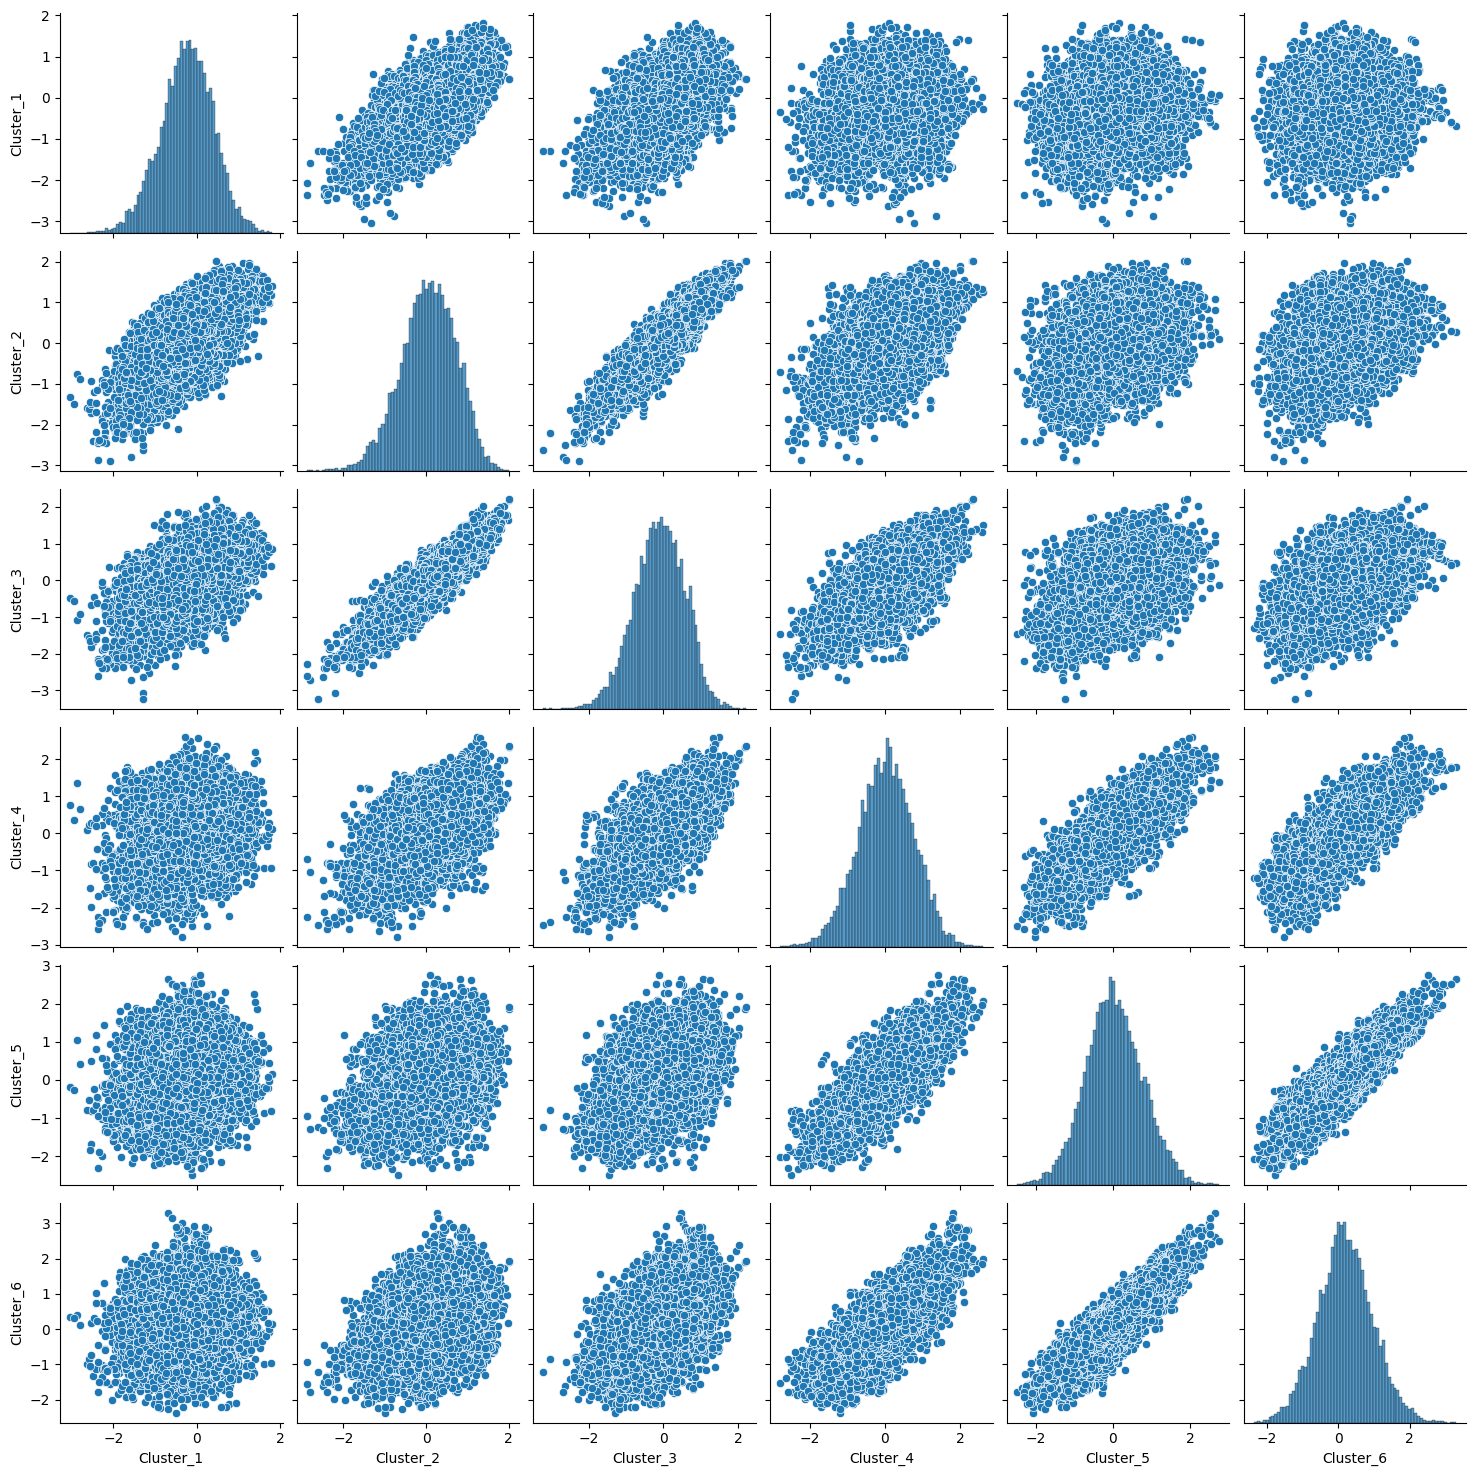

In [17]:
import seaborn as sns
g=sns.pairplot(data_df,corner=False)

In [27]:
pc_alpha=0.005
quantile=1

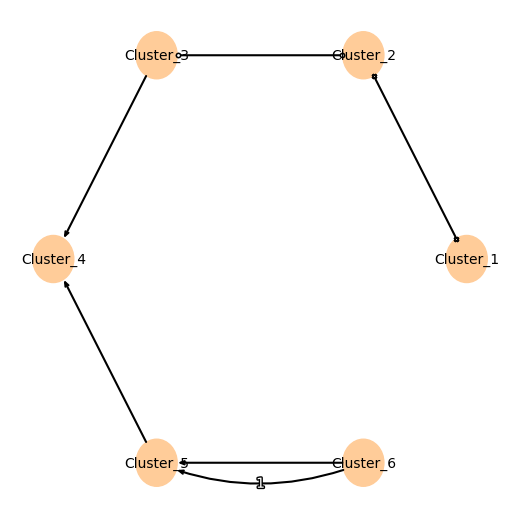

In [29]:


resultsThisPaper,results_tail=method_this_paper(data_df,pc_alpha=pc_alpha,quantile=quantile,tau_max=1)
save_path=os.path.join(log_path,f"upper_tail_causal_quant{quantile}_alpha{pc_alpha}.png")
draw_graph(edge_shape=resultsThisPaper,arrow_linewidth=3,arrowhead_size=5,label_fontsize=10,node_size=0.2,figsize=(5,5),var_names=data_df.columns,save_path=save_path)

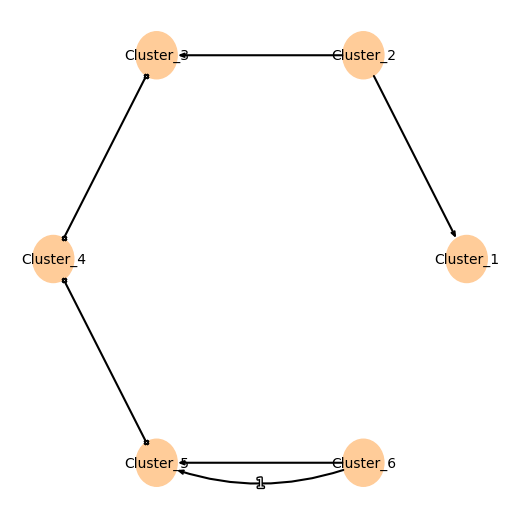

In [32]:
resultsThisPaper,results_tail=method_this_paper(-data_df,pc_alpha=pc_alpha,quantile=quantile,tau_max=1)
save_path=os.path.join(log_path,f"lower_tail_causal_quant{quantile}_alpha{pc_alpha}.png")
draw_graph(edge_shape=resultsThisPaper,arrow_linewidth=3,arrowhead_size=5,label_fontsize=10,node_size=0.2,figsize=(5,5),var_names=data_df.columns,save_path=save_path)

In [36]:
resultsThisPaper.shape

(6, 6, 2)

In [41]:
data_df_bar.shape

(13784, 12)

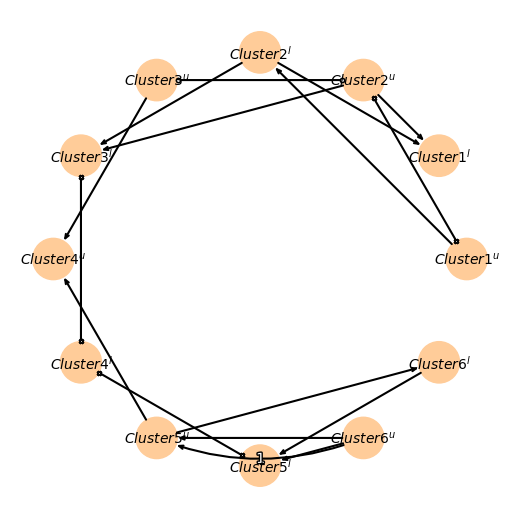

In [42]:
def expand_data_df(data_df):

    X_bar = np.concatenate([data_df, -data_df], axis=1)
    data_df_bar=pd.DataFrame(X_bar,columns=[f"{x.replace('_','')}.u" for x in data_df.columns]+[f"{x.replace('_','')}.l" for x in data_df.columns])
    return data_df_bar

data_df_bar=expand_data_df(data_df)
resultsThisPaper,results_tail=method_this_paper(data_df_bar,pc_alpha=pc_alpha,quantile=quantile,tau_max=1,both_tail_variable=data_df.shape[1])
save_path=os.path.join(log_path,f"both_tail_causal_quant{quantile}_alpha{pc_alpha}.png")
var_names=np.array([f"${x.replace('_','')}^{{u}}$" for x in data_df.columns]+[f"${x.replace('_','')}^{{l}}$" for x in data_df.columns])
draw_graph(arrow_linewidth=3,arrowhead_size=5,label_fontsize=10,node_size=0.2,figsize=(5,5),**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)